In [1]:
import os
import glob
import time
import torch

import pickle
from torch_geometric.data import Data



import networkx as nx
import matplotlib.pyplot as plt


In [2]:

from utils import k_hop_subgraph_with_default_whole_graph
with open(f'../dataset/Tree/Tree_cycle_160_v0.pkl', 'rb') as fin:
    data = pickle.load(fin).to(device)


In [8]:
node_idx = 720
hops =  4
num_nodes, num_edges = data.x.size(0), data.edge_index.size(1)

subset, edge_index, _, edge_mask = k_hop_subgraph_with_default_whole_graph(
    node_idx, hops , data.edge_index, relabel_nodes=True,
    num_nodes=num_nodes)


tensor([  73,  715,  716,  717,  718,  719,  720, 1059], device='cuda:0')
tensor([  73,  715,  716,  717,  718,  719,  720, 1059], device='cuda:0')


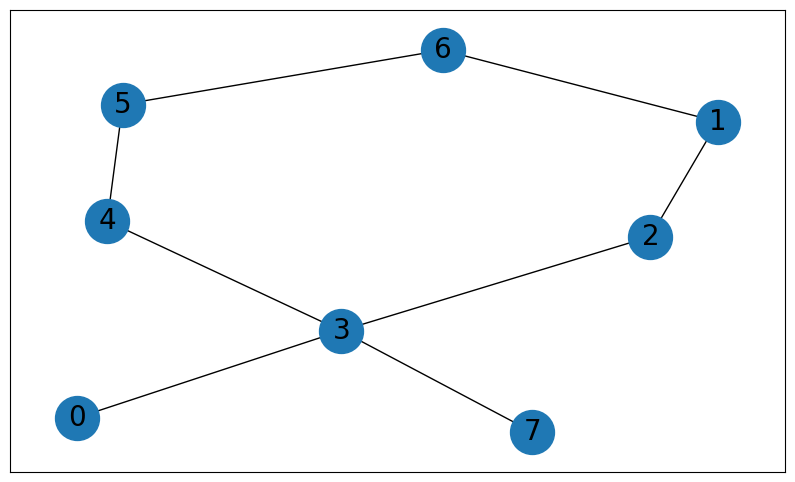

In [9]:
print(subset)
node_dict = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple', 4: 'yellow'}
# 그래프 생성
G1 = nx.Graph()  # 방향 그래프 생성
print(subset)
# 엣지 추가
for i in range(edge_index.shape[1]):
    src = edge_index[0, i].item()
    tgt = edge_index[1, i].item()
    G1.add_edge(src, tgt)

# 그래프 시각화
plt.figure(figsize=(10, 6))
# pos = nx.draw_networkx(G)  # 그래프 레이아웃 설정
nx.draw_networkx(G1, with_labels=True, node_size=1000, font_size=20)  # 그래프 그리기
# plt.title("Graph Visualization", fontsize=15)
plt.show()

In [2]:
class arguments:
    pass

In [6]:
args = arguments()
args.dataset = 'BA_Community'
args.date = '0809'
args.beta = '2.0'
args.alpha = 0.0

In [7]:
from gnn.gcn_syn import GCN as GCN_syn

device = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
if "ba_shapes" in args.dataset.lower():
    gnnNets = GCN_syn(nfeat=10, nhid=128, nclass=4, device=device,
                      dropout=0.0)
    gnnNets.load_state_dict(torch.load("./models/0808/gcn_ba_shapes_epochs1000_lr0.001_v1.pt"))
elif 'community' in args.dataset.lower():
    gnnNets = GCN_syn(nfeat=10, nhid=256, nclass=8, device=device,
                      dropout=0.0)
    gnnNets.load_state_dict(torch.load("./models/0808/gcn_BA_Community_epochs1000_lr0.003_v1.pt"))

gnnNets = gnnNets.to(device)

In [8]:
from sklearn.metrics import roc_auc_score

v1 = []
args.version = 'v1_8'
for i in range(300,700):
    save_dir = os.path.join(f'./results/{args.date}/{args.dataset}/beta_{args.beta}/'
                                     f"{args.version}_pgexplainer")
    # print(save_dir)
    file = glob.glob(os.path.join(save_dir, f"node_{i}.pt"))[0]
    edge_mask, x, edge_index, y, subset, edge_reals = torch.load(file)
    edge_mask = torch.from_numpy(edge_mask)
    node_idx = int(torch.where(subset == i)[0])

    sub_data = Data(x=x, edge_index=edge_index, y=y).to(device)
    pred_ori = gnnNets(sub_data)[1][node_idx].argmax(dim=-1)

    threshold = float(edge_mask.reshape(-1).sort(descending=True).values[min(12, edge_mask.shape[0]-1)])
    hard_mask = (edge_mask > threshold).cpu()
    # if y[node_idx] == pred_ori:
    v1 .append( roc_auc_score(edge_reals, edge_mask) )
v1 = torch.tensor(v1)
print(v1.min())
print(save_dir)
print(v1.mean())


tensor(0., dtype=torch.float64)
./results/0809/BA_Community/beta_2.0/v1_8_pgexplainer
tensor(0.2768, dtype=torch.float64)


In [7]:
print(torch.where(v1==v1.min()))

(tensor([81]),)


In [9]:
args.dataset = 'BA_Community'

In [10]:
v3 = []
acc = []
args.version = 'v1_8'
for i in range(300,700):
    save_dir = os.path.join(f'./results/{args.date}/{args.dataset}/beta_{args.beta}/'
                                     f"{args.version}_pgexplainer")

    file = glob.glob(os.path.join(save_dir, f"node_{i}.pt"))[0]
    edge_mask, x, edge_index, y, subset, edge_reals = torch.load(file)
    edge_mask = torch.from_numpy(edge_mask)
    node_idx = int(torch.where(subset == i)[0])

    sub_data = Data(x=x, edge_index=edge_index, y=y).to(device)
    pred_ori = gnnNets(sub_data)[1][node_idx].argmax(dim=-1)

    threshold = float(edge_mask.reshape(-1).sort(descending=True).values[min(12, edge_mask.shape[0]-1)])
    hard_mask = (edge_mask > threshold).cpu()

    v3.append( roc_auc_score(edge_reals, edge_mask) )
    acc.append((edge_reals==hard_mask).sum() / len(hard_mask))
v3 = torch.tensor(v3)
acc = torch.tensor(acc)
print(v3.min())

threshold = float(acc.reshape(-1).sort(descending=False).values[min(50, acc.shape[0]-1)])
hard_mask = (acc <= threshold).cpu()
print(torch.where(hard_mask))


print(acc.min())
print(torch.where(acc==acc.min()))
print(acc.mean())

tensor(0., dtype=torch.float64)
(tensor([  0,   1,  11,  13,  14,  20,  22,  24,  31,  33,  45,  47,  50,  52,
         54,  60,  61,  85,  87,  89, 100, 102, 105, 107, 109, 120, 122, 145,
        147, 149, 156, 158, 159, 190, 192, 260, 261, 265, 267, 270, 271, 291,
        293, 294, 306, 308, 309, 326, 328, 329, 340, 341, 366, 368]),)
tensor(0.0769)
(tensor([ 45,  47,  50,  52,  54, 190, 192, 265, 267]),)
tensor(0.6335)


In [272]:
print(pred_label[torch.where(hard_mask)[0]+300])
print(data.y[torch.where(hard_mask)[0]+300])

NameError: name 'pred_label' is not defined

In [176]:
print(v3[100])

tensor(1., dtype=torch.float64)


In [11]:
ori_node_idx = 300 + 0

args.version = 'v1_8'
save_dir = os.path.join(f'./results/{args.date}/{args.dataset}/beta_{args.beta}/'
                                     f"{args.version}_pgexplainer")
print(save_dir)
file = glob.glob(os.path.join(save_dir, f"node_{ori_node_idx}.pt"))[0]
edge_mask, x, edge_index, y, subset, edge_reals = torch.load(file)
edge_mask = torch.from_numpy(edge_mask)
node_idx = int(torch.where(subset == ori_node_idx)[0])

sub_data = Data(x=x, edge_index=edge_index, y=y).to(device)
pred_ori = gnnNets(sub_data)[1][node_idx].argmax(dim=-1)

threshold = float(edge_mask.reshape(-1).sort(descending=True).values[min(12, edge_mask.shape[0]-1)])
hard_mask = (edge_mask > threshold).cpu()

print(pred_ori.item(), y[node_idx])
print("index", node_idx)
print(edge_index)

./results/0809/BA_Community/beta_2.0/v1_8_pgexplainer
1 tensor(1)
index 8
tensor([[ 0,  1,  2,  2,  3,  4,  4,  4,  4,  4,  4,  4,  5,  6,  6,  7,  8,  8,
          8,  9,  9,  9, 10, 10, 11, 11, 12, 12,  4, 12],
        [ 4,  4,  4,  6,  4,  0,  1,  2,  3,  5,  6,  7,  4,  2,  4,  4,  9, 11,
         12, 12, 10,  8,  9, 11, 10,  8,  8,  9, 12,  4]])


In [12]:
roc_auc_score(edge_reals, edge_mask)

0.33333333333333337

In [13]:
node_dict = {0:'red', 1:'blue', 2:'green', 3:'purple',4 :'red', 5:'blue', 6:'green', 7:'purple',  8:'yellow'}

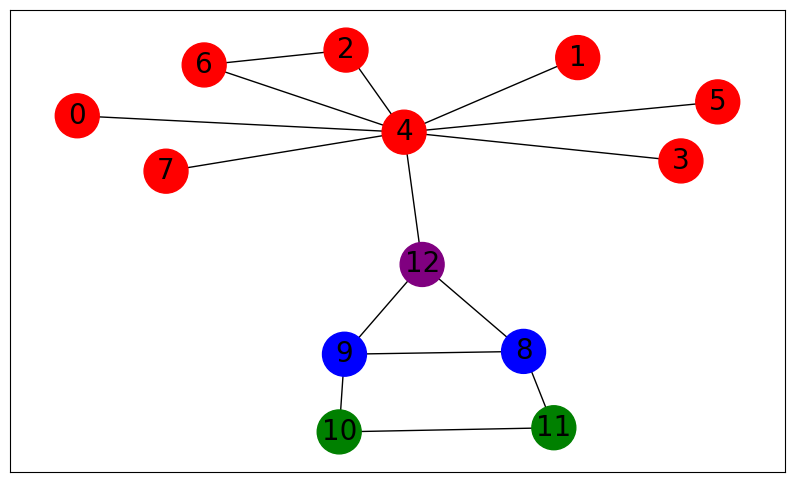

In [14]:
# 그래프 생성
G0 = nx.Graph()  # 방향 그래프 생성

# 엣지 추가
for i in range(edge_index.shape[1]):

    src = edge_index[0, i].item()
    tgt = edge_index[1, i].item()
    G0.add_edge(src, tgt)

# 그래프 시각화
plt.figure(figsize=(10, 6))
# pos = nx.draw_networkx(G)  # 그래프 레이아웃 설정
nx.draw_networkx(G0, with_labels=True, node_size=1000, font_size=20, node_color = [node_dict[int(y[n])] for n in list(G0.nodes())])  # 그래프 그리기
# plt.title("Graph Visualization", fontsize=15)
plt.show()

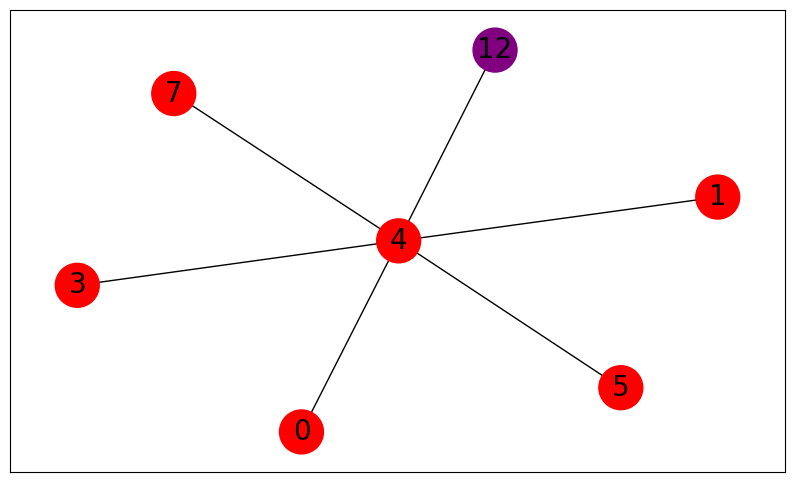

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.])
tensor([0.0013, 0.0013, 0.0003, 0.0001, 0.0013, 0.0013, 0.0013, 0.0003, 0.0013,
        0.0013, 0.0003, 0.0013, 0.0013, 0.0001, 0.0003, 0.0013, 0.0004, 0.0004,
        0.0006, 0.0007, 0.0004, 0.0004, 0.0004, 0.0005, 0.0005, 0.0004, 0.0006,
        0.0007, 0.0009, 0.0009])
0.0007090041181072593


In [15]:
G1 = nx.Graph()  # 방향 그래프 생성
# 엣지 추가
for i in range(hard_mask.shape[0]):
    if hard_mask[i] :
        src = edge_index[0, i].item()
        tgt = edge_index[1, i].item()
        G1.add_edge(src, tgt)

# 그래프 시각화
plt.figure(figsize=(10, 6))
# pos = nx.draw_networkx(G)  # 그래프 레이아웃 설정
nx.draw_networkx(G1, with_labels=True, node_size=1000, font_size=20, node_color = [node_dict[int(y[n])] for n in list(G1.nodes())])  # 그래프 그리기
# plt.title("Graph Visualization", fontsize=15)
plt.show()
print(edge_reals)
print(edge_mask)
print(threshold)

In [338]:
args.version = 'v2_42'

In [339]:

save_dir = os.path.join(f'./results/{args.date}/{args.dataset}/beta_{args.beta}/'
                                     f"{args.version}_pgexplainer")

file = glob.glob(os.path.join(save_dir, f"node_{ori_node_idx}.pt"))[0]
edge_mask, x, edge_index, y, subset, edge_reals = torch.load(file)
edge_mask = torch.from_numpy(edge_mask)
node_idx = int(torch.where(subset == ori_node_idx)[0])

sub_data = Data(x=x, edge_index=edge_index, y=y).to(device)
pred_ori = gnnNets(sub_data)[1][node_idx].argmax(dim=-1)

threshold = float(edge_mask.reshape(-1).sort(descending=True).values[min(12, edge_mask.shape[0]-1)])
hard_mask = (edge_mask > threshold).cpu()

In [340]:
edge_mask, threshold, float(edge_mask.reshape(-1).sort(descending=True).values[min(12, edge_mask.shape[0]-1)])

(tensor([0.0613, 0.0613, 0.1105, 0.0863, 0.0613, 0.0613, 0.0613, 0.1105, 0.0613,
         0.0613, 0.1223, 0.0613, 0.0613, 0.0863, 0.1223, 0.0613, 0.2021, 0.1508,
         0.1174, 0.1231, 0.1435, 0.2021, 0.1435, 0.1139, 0.1139, 0.1508, 0.1174,
         0.1231, 0.1063, 0.1063, 0.0845, 0.0845]),
 0.11394059658050537,
 0.11394059658050537)

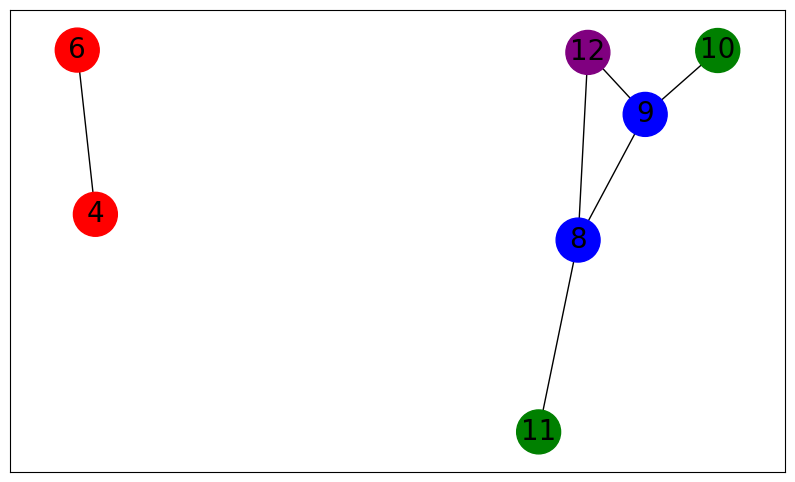

In [343]:
# 그래프 생성
G2 = nx.Graph()  # 방향 그래프 생성

# 엣지 추가
for i in range(edge_reals.shape[0]):
    if hard_mask[i] :
        src = edge_index[0, i].item()
        tgt = edge_index[1, i].item()
        G2.add_edge(src, tgt)

# 그래프 시각화
plt.figure(figsize=(10, 6))
# pos = nx.draw_networkx(G)  # 그래프 레이아웃 설정
nx.draw_networkx(G2, with_labels=True, node_size=1000, font_size=20, node_color = [node_dict[int(y[n])] for n in list(G2.nodes())])  # 그래프 그리기
# plt.title("Graph Visualization", fontsize=15)
plt.show()

In [252]:
roc_auc_score(edge_reals, edge_mask)

0.6666666666666666

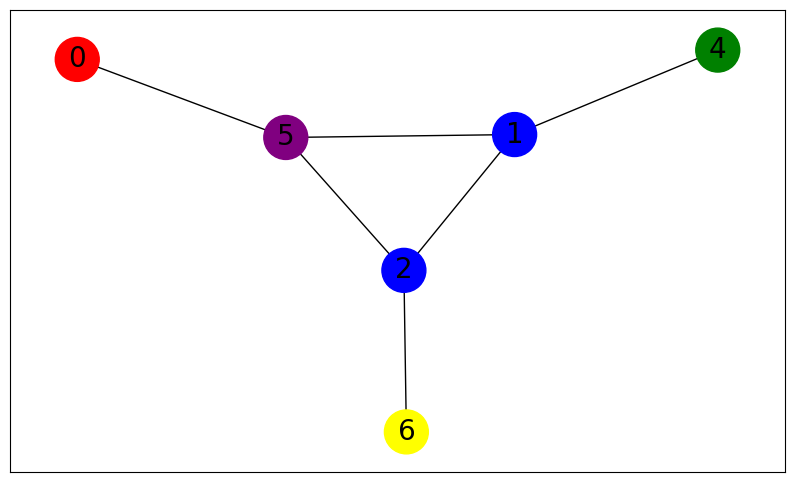

In [253]:
plt.figure(figsize=(10, 6))
# pos = nx.draw_networkx(G)  # 그래프 레이아웃 설정
nx.draw_networkx(G1, with_labels=True, node_size=1000, font_size=20, node_color = [node_dict[int(y[n])] for n in list(G1.nodes())])  # 그래프 그리기
# plt.title("Graph Visualization", fontsize=15)
plt.show()

In [254]:
with open(f'../dataset/ba_shapes/ba_shapes_{300}_{"v3"}.pkl', 'rb') as fin:
    data = pickle.load(fin)
    data.to(device)

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/ba_shapes/ba_shapes_300_v3.pkl'

In [255]:
a, pred, b = gnnNets(data)
import torch.nn.functional as F


In [256]:
# en = F.cross_entropy(pred, pred, reduction='none')
en = -(pred* torch.log(pred)).sum(dim=-1)
print(pred.shape, en.shape)
print(en[0])
print(pred[0])
print(a[0])
# print(b[0])
print( (- pred[0] * torch.log(pred[0])).sum() )

torch.Size([1151, 4]) torch.Size([1151])
tensor(0.2372, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.0052, 0.0168, 0.9522, 0.0258], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-1.9297, -0.7655,  3.2728, -0.3351], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(0.2372, device='cuda:0', grad_fn=<SumBackward0>)


In [26]:
for i in range(300,700):
    print(i, pred[i])
    print(en[i].item())
    # print( en[i*10 + j] for j in range(10) )

300 tensor([0.0298, 0.9429, 0.0190, 0.0082], device='cuda:0',
       grad_fn=<SelectBackward0>)
0.2749713063240051
301 tensor([0.1142, 0.4524, 0.3546, 0.0789], device='cuda:0',
       grad_fn=<SelectBackward0>)
1.174554705619812
302 tensor([0.0372, 0.0393, 0.9046, 0.0189], device='cuda:0',
       grad_fn=<SelectBackward0>)
0.41539832949638367
303 tensor([0.1468, 0.0844, 0.6003, 0.1686], device='cuda:0',
       grad_fn=<SelectBackward0>)
1.0967669486999512
304 tensor([0.2336, 0.0451, 0.2010, 0.5203], device='cuda:0',
       grad_fn=<SelectBackward0>)
1.1418650150299072
305 tensor([0.0147, 0.9412, 0.0423, 0.0018], device='cuda:0',
       grad_fn=<SelectBackward0>)
0.2642032504081726
306 tensor([0.5638, 0.1430, 0.1658, 0.1274], device='cuda:0',
       grad_fn=<SelectBackward0>)
1.1617132425308228
307 tensor([0.0443, 0.2553, 0.6918, 0.0086], device='cuda:0',
       grad_fn=<SelectBackward0>)
0.782508134841919
308 tensor([0.0615, 0.0407, 0.2987, 0.5990], device='cuda:0',
       grad_fn=<Sel

In [27]:
print(en[:700].mean(), en[700:].mean())

tensor(0.5052, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.7318, device='cuda:0', grad_fn=<MeanBackward0>)


In [28]:
from sklearn.metrics import roc_auc_score
v1 = roc_auc_score(edge_reals, edge_mask)
print(v1)

0.99
